In [473]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from category_encoders import WOEEncoder
from sklearn.impute import KNNImputer
from scipy.stats import pointbiserialr
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [474]:
train_pkl = pd.read_pickle('train.pkl')
test_pkl = pd.read_pickle('test_oot.pkl')

target = 'fpd15'

In [475]:
train = train_pkl.copy()
test = test_pkl.copy()

In [476]:
def preprocessing_and_woe_encoder(df, target_col=None, fit_encoder=True, woe_encoder=None, categorical_cols=None):
    df = df.copy()

    if target_col is not None: # тестовой выборке этот столбец заполнен NaN
        df = df.dropna(subset=[target_col])

    df = df.replace([None, 'None', 'nan', 'NaN', ''], np.nan)

    # оптимизация использования памяти
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')

    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')

    # преобразование типа работодателя
    df['employer_type'] = df['onemployername'].apply(
        lambda x: (
            'ИП' if any(kw in str(x) for kw in ['ИП', 'Индивидуальный предприниматель']) else
            'Самозанятый' if 'самозанятый' in str(x).lower() else
            'ООО' if any(kw in str(x) for kw in ['ООО', 'Общество с ограниченной ответственностью']) else
            'АО' if any(kw in str(x) for kw in ['АО', 'Акционерное общество']) and 'ПАО' not in str(x) else
            'ПАО' if any(kw in str(x) for kw in ['ПАО', 'Публичное акционерное общество']) else
            'ГУП/МУП' if any(kw in str(x) for kw in ['ГУП', 'МУП', 'Государственное унитарное предприятие']) else
            'НКО' if any(kw in str(x) for kw in ['НКО', 'Некоммерческая организация']) else
            'Филиал' if 'филиал' in str(x).lower() else
            'ТСЖ' if 'ТСЖ' in str(x) else
            'Госорган' if any(kw in str(x) for kw in ['Министерство', 'Администрация', 'Управление', 'Департамент']) else
            'NaN' if pd.isna(x) else
            'Другое'
        )
    )
    df.drop(columns=['onemployername'], inplace=True)

    df['age'] = (pd.to_datetime('today') - pd.to_datetime(df['onbirthdate'])).dt.days // 365  # возраст клиента вместо даты рождения
    df['passport_age'] = (pd.to_datetime('today') - pd.to_datetime(df['onpassportissuedate'])).dt.days // 365  # сколько лет действует текущий паспорт вместо даты выдачи
    df.drop(columns=['onbirthdate', 'onpassportissuedate'], inplace=True)

    # удаляю совсем неинформативные столбцы
    df = df.drop(columns=['reg_address_house', 'liv_address_house', 'reg_address_flat', 'liv_address_flat']) # точные адреса (номера домов)
    df = df.drop(columns=[col for col in df.columns if 'photo' in col]) # информацию о фотографии
    df = df.loc[:, df.nunique() > 1]       # константные столбцы
    # df = df.dropna(axis=1, how='all')      # полностью пустые столбцы
    df = df.loc[:, df.isnull().mean() < 0.5]  # столбцы с >50% пропусков

    if target_col is None:
        df[target] = np.nan

    # WoE-кодирование
    if categorical_cols is None:
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
        categorical_cols = [col for col in categorical_cols if col not in ['application_id_axi', 'application_date']]  # убираю id и дату заявки для заполнения пропусков

    print('Кодируем следующие столбцы:', categorical_cols)

    # заполняю пропуски в категориальных признаках перед кодированием
    for col in categorical_cols:
        df[col] = df[col].astype(str)
        df[col] = df[col].replace('nan', 'Другое')  # nan появляется после astype(str)

    if fit_encoder or woe_encoder is None:
        woe_encoder = WOEEncoder(cols=categorical_cols)
        woe_encoder.fit(df[categorical_cols], df[target_col])

    df_woe = woe_encoder.transform(df[categorical_cols])
    df = pd.concat([df.drop(columns=categorical_cols), df_woe], axis=1)

    df = df.replace([None, 'None', 'nan', 'NaN', ''], np.nan)

    if target_col is not None:
        return df, woe_encoder, categorical_cols
    else:
        return df


In [477]:
def auto_fill_missing_values(df, numeric_strategy='median', n_neighbors=3):
    df_filled = df.copy()

    for col in df.columns:
        # пропускаем столбцы без пропусков
        if df[col].isnull().sum() == 0:
            continue

        # тип столбца
        col_dtype = df[col].dtype
        n_unique = df[col].nunique()

        # бинарные фичи
        if n_unique <= 2 or col_dtype == 'bool':
            df_filled[col] = df[col].fillna(0)

        # категориальные фичи - заполняю медианой
        elif col_dtype == 'object' or (n_unique <= 20 and col_dtype != 'float64'):
            mode_val = df[col].mode()[0]
            df_filled[col] = df[col].fillna(mode_val)

        # финансовые фичи - заполняю нулями
        elif 'amt' in col.lower() or 'bal' in col.lower() or 'due' in col.lower():
            df_filled[col] = df[col].fillna(0.0)

        # прочие числовые фичи
        else:
          imputer = KNNImputer(n_neighbors=n_neighbors)
          df_filled[col] = imputer.fit_transform(df[[col]])[:, 0]

    return df_filled


### Первичная обработка данных
1) очистка \
2) преобразование \
3) аггрегация \
4) WoE-кодирование категориальных признаков \
5) заполнение пропусков

In [478]:
# обработка тренировочных данных с fit_encoder=True
processed_train, woe_encoder, categorical_cols = preprocessing_and_woe_encoder(train, target_col=target, fit_encoder=True)

# Обрабатываем тестовые данные с уже обученным энкодером
processed_test = preprocessing_and_woe_encoder(test, target_col=None, fit_encoder=False, woe_encoder=woe_encoder, categorical_cols=categorical_cols)

Кодируем следующие столбцы: ['ofgender', 'workoccupation', 'workposition', 'gosusl', 'reg_address_index', 'liv_address_index', 'employer_type']
Кодируем следующие столбцы: ['ofgender', 'workoccupation', 'workposition', 'gosusl', 'reg_address_index', 'liv_address_index', 'employer_type']


In [479]:
train_data = processed_train.copy()
test_data = processed_test.copy()

# отделяю то, что не нужно трогать при заполнении пропусков
train_tepm = train_data.loc[:, ['application_id_axi', 'application_date', 'finalscore_point', 'limit_final']]
test_tepm = test_data.loc[:, ['application_id_axi', 'application_date', 'finalscore_point', 'limit_final']]

train_data.drop(columns=['application_id_axi', 'application_date'], inplace=True)
train_data.drop(columns=['finalscore_point', 'limit_final'], inplace=True) # убираю неизвестные на момент скоринга фичи, чтобы отобрать фичи для обучения

test_data.drop(columns=['application_id_axi', 'application_date', 'finalscore_point', 'limit_final'], inplace=True)

In [480]:
train_data_filled = auto_fill_missing_values(train_data)
test_data_filled = auto_fill_missing_values(test_data)

In [481]:
train_filled = pd.concat([train_tepm, train_data_filled], axis=1)
test_filled = pd.concat([test_tepm, test_data_filled], axis=1)

In [482]:
train_filled

,application_id_axi,application_date,finalscore_point,limit_final,sourcedeviceclientformcount,sourceipclientformcount,customerincomecurrent,requestlimit,educationapplication,countuniqedevicepern,...,cntuniquephones365nbki,age,passport_age,ofgender,workoccupation,workposition,gosusl,reg_address_index,liv_address_index,employer_type
1,5619295-1,2023-12-01,0.178589,10000.0,2,0,88012,20000,3,0,...,3.0,26,6,0.070326,0.056916,0.186309,0.032233,0.000000,-1.087545,-0.084645
4,5619404-1,2023-12-01,0.132080,14000.0,0,0,60000,10000,4,0,...,3.0,36,16,0.070326,0.069831,-0.149467,0.032233,-0.468506,-0.468506,0.067234
5,5619413-1,2023-12-01,0.243652,8000.0,216,51,44666,10000,3,0,...,1.0,36,2,0.070326,0.118421,0.129337,0.032233,1.254261,1.254261,0.080930
7,5619430-1,2023-12-01,0.304199,4000.0,41401,0,45000,10000,3,0,...,1.0,38,18,0.070326,0.069831,0.129337,0.032233,-0.314355,0.378792,-0.084645
10,5619466-1,2023-12-01,0.180908,5000.0,2,0,55000,5000,2,0,...,1.0,40,20,0.070326,0.067102,0.129337,0.032233,0.784257,0.784257,0.011863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54951,6256794-1,2024-03-18,0.325195,4000.0,1,3,120000,10000,3,0,...,1.0,46,1,0.070326,0.069831,0.129337,-0.060154,0.561114,0.666474,0.067234
54953,6256818-1,2024-03-18,0.249146,8000.0,56,2,60000,30000,3,0,...,2.0,29,6,-0.085881,0.056916,0.082650,0.032233,0.000000,0.000000,0.080930
54954,6256821-1,2024-03-18,0.187256,10000.0,46,0,58000,15000,5,0,...,1.0,22,2,0.070326,-0.181729,-0.149467,-0.060154,0.378792,0.378792,0.080930
54955,6256827-1,2024-03-18,0.364990,3000.0,87,29,28387,7000,2,0,...,2.0,36,16,-0.085881,-0.455341,0.129337,0.032233,1.882654,1.882654,-0.084645


### Отбор фичей

In [483]:
df = train_data_filled.copy()
X = df.drop(columns='fpd15')
y = df['fpd15']

In [484]:
# вычисление корреляций с таргетом
correlations = {}
for col in tqdm(df.columns.drop(target)):
    corr, _ = pointbiserialr(df[col], df[target])
    correlations[col] = abs(corr)

# предварительный отбор топ-200 фичей по корреляции
N = 200
top_features = sorted(correlations, key=correlations.get, reverse=True)[:N]

100%|██████████| 2115/2115 [00:12<00:00, 174.48it/s]


In [485]:
# строю корреляционную матрицу для отобранных фичей
corr_matrix = df[top_features].corr().abs()

# итеративное удаление коррелирующих фичей
selected_features = []
for feature in top_features:
    # проверяю корреляцию с уже отобранными фичами
    if all(corr_matrix.loc[feature, selected].max() < 0.5 for selected in selected_features): # чтобы убрать сильно коррелирующие фичи
        selected_features.append(feature)
    if len(selected_features) >= 20:
        break

In [486]:
corr_data = pd.DataFrame()
corr_data['feature'] = selected_features
corr_data['target_corr'] = [correlations[f] for f in selected_features]

print(corr_data.sort_values(by='target_corr', ascending=False))

                                feature  target_corr
0                     liv_address_index     0.382535
1          avgcurbal_shpastdueall90nbki     0.104004
2     cntpaymmore100all365goodpaymtnbki     0.095398
3            avgcurbal_shpastdueallnbki     0.091614
4         avgpastdue_shcurbalall180nbki     0.088135
5     avgcurbal_shoutstall180closednbki     0.082153
6   avgcurbal_shpastdueall180activenbki     0.072083
7   avgoutstpastdue_dlimitall365badnbki     0.069641
8                       cntall90badnbki     0.068420
9                     cntallinquirynbki     0.068182
10           avgpastdue_shcurbalallnbki     0.067322
11                  sumlimitallgoodnbki     0.066985
12                         workposition     0.062258
13                  cntuniquephonesnbki     0.061051
14          sumpaymall60activepaymtnbki     0.060279
15                       workoccupation     0.058345


In [487]:
from google.colab import files

corr_data.to_excel('selected_features.xlsx', index=False)
files.download('/content/selected_features.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

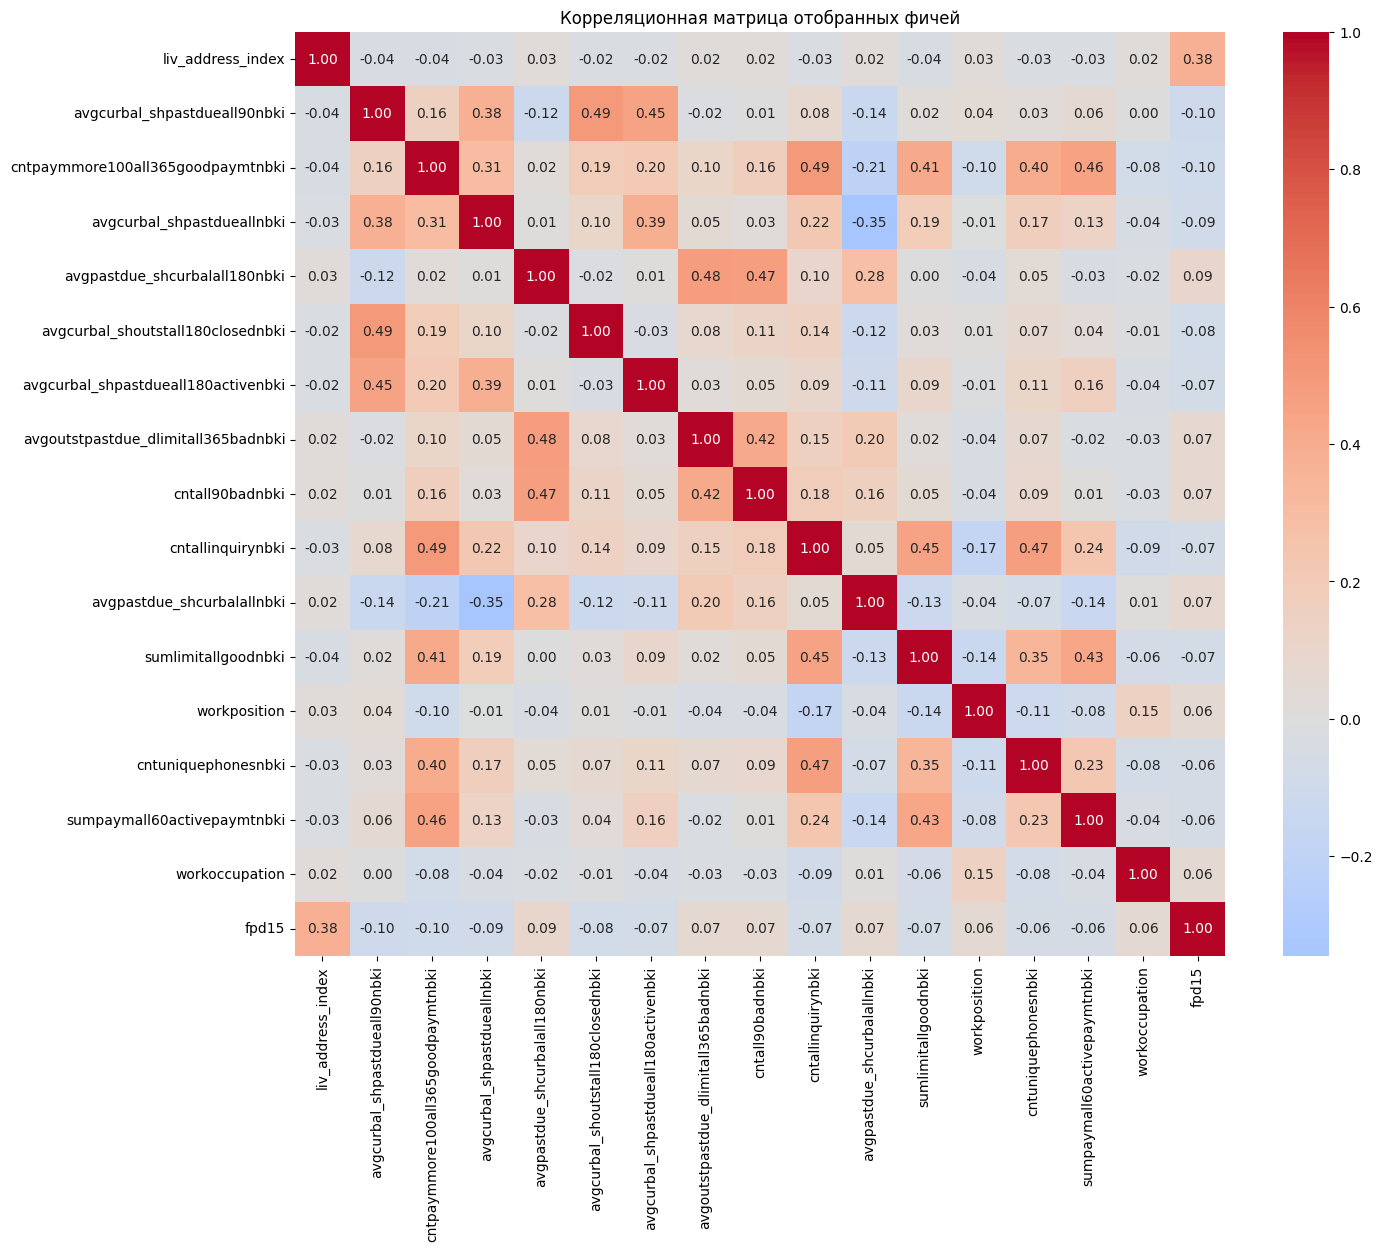

In [488]:
final_corr = df[selected_features + [target]].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(final_corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Корреляционная матрица отобранных фичей")
plt.show()

### Обучение модели

In [489]:
selected_features = corr_data['feature']

In [490]:
X_train = train_data_filled[selected_features]
y_train = train_data_filled[target]

X_test = test_data_filled[selected_features]
y_test = test_data_filled[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(
    max_iter=1000,
    solver='saga',
    penalty='l1',
    C=0.1,
    random_state=42,
    class_weight='balanced'
)
model.fit(X_train_scaled, y_train)

logits = model.decision_function(X_test_scaled)
probabilities = 1 / (1 + np.exp(-logits))

result = pd.DataFrame({
    'application_id_axi': test_tepm['application_id_axi'],
    'score': probabilities
})

result

,application_id_axi,score
2591,6263684-1,0.664380
2592,6263717-1,0.405394
2593,6263719-1,0.197963
2594,6263722-1,0.804382
2595,6263727-1,0.339553
...,...,...
37836,6335869-1,0.492396
37837,6335879-1,0.855020
37838,6335887-2,0.403650
37839,6335902-1,0.365453


In [491]:
check_result = pd.merge(
    test_tepm[['application_id_axi', 'finalscore_point']],
    result,
    on='application_id_axi',
    how='left'
)

In [492]:
check_result.head(50)

,application_id_axi,finalscore_point,score
0,6263684-1,0.598633,0.664380
1,6263717-1,0.105713,0.405394
2,6263719-1,0.210815,0.197963
3,6263722-1,0.583496,0.804382
4,6263727-1,0.348877,0.339553
5,6263736-1,0.297363,0.412646
6,6263753-1,0.176880,0.271293
7,6263770-1,0.106201,0.312108
8,6263800-1,0.035797,0.695243
9,6263803-1,0.230835,0.679578


In [493]:
result.to_pickle('scoring_result.pkl')
files.download('/content/scoring_result.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>